## Problem

I want to practice SQL and Python on datasets resembling what I might encounter at a marketplace company like Uber, Lyft, or Doordash. The 538 [Uber Pickups in New York City](https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city/data) dataset exists, but contains mostly location data:

In [1]:
import pandas as pd

In [2]:
foil_538 = pd.read_csv("data/uber/uber-foil.csv", parse_dates=["date"])
foil_538.head(3)

,dispatching_base_number,date,active_vehicles,trips
0,B02512,2015-01-01,190,1132
1,B02765,2015-01-01,225,1765
2,B02764,2015-01-01,3427,29421


In [3]:
dapr_538 = pd.read_csv("data/uber/uber-raw-apr14.csv", parse_dates=["Date/Time"])
dapr_538.head(3)

,Date/Time,Lat,Lon,Base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512


## Solution

Generate an entire universe of simulated data. Duh.

In this universe, our ridesharing data exists in four tables:

**trips**

* id - integer
* pilot - integer
* passenger - integer
* planet - id
* trip_completed - boolean
* trip_requested - timestamp
* trip_started - timestamp
* trip_ended - timestamp
* price - integer
* pilot_rating - integer
* passenger_rating - integer

**planets**

* id - integer
* name - string

**pilots**

* id - integer
* rating - integer
* banned - boolean
* created - timestamp

**passengers**

* id - integer
* rating - integer
* banned - boolean
* created - timestamp

Yes, when I said "universe" I meant it literally.

## Planets

Let's start with planets, which seems like it should be pretty easy.

In [4]:
planets = ["Alderaan", "Chandrila", "Corellia", "Coruscant", "Duro", "Hosnian Prime", "Kuat"]

I know that I'm listing core worlds only, and I can already hear your accusations about my liberal core world elitism, but the reality is that worlds in the outer rim simply don't have the infrastructure to support ridesharing on the scale we're interested in. 

Pilots and passengers do occasionally arrange shared rides within and between systems, but these trips are usually negotiated in a more informal setting like, for example, a cantina.

In [5]:
df_planets = pd.DataFrame({"name": planets})
df_planets

,name
0,Alderaan
1,Chandrila
2,Corellia
3,Coruscant
4,Duro
5,Hosnian Prime
6,Kuat


## Pilots

Let's say that we have about 100 pilots in our system. Pilot maintain a rating between 1 and 5 stars. Just like in our world, passengers in our simulated universe tend to be pretty nice when rating pilots, so a distribution of pilot ratings would be skewed towards the higher end: 

In [6]:
%matplotlib inline
import numpy as np
import scipy.stats as stats

In [7]:
pilot_ratings = np.concatenate((
    stats.norm.rvs(loc=4.5, scale=0.3, size=70),
    stats.skewnorm.rvs(a=-1, loc=4, scale=1, size=30)
)).clip(0.01, 4.99)

df_pilots = pd.DataFrame({"rating" : pilot_ratings}, index=[range(len(pilot_ratings))])

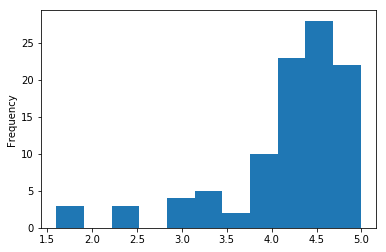

In [43]:
_ = df_pilots["rating"].plot(kind="hist", bins=11)

Next, some portion of pilots have been banned from our system. Pilots with low ratings are more likely to be banned:

In [9]:
df_pilots["banned"] = 0

pct_75 = df_pilots["rating"].quantile(0.75)
pct_50 = df_pilots["rating"].quantile(0.50)

pilots_abv_75th_pct = (df_pilots["rating"] >= pct_75)
pilots_abv_50th_pct = ((df_pilots["rating"] >= pct_50) & (df_pilots["rating"] < pct_75))
pilots_blw_50th_pct = (df_pilots["rating"] < pct_50)

df_pilots.loc[pilots_abv_75th_pct, "banned"] = np.random.choice([1, 0], size=25, p=[0.05, 0.95])
df_pilots.loc[pilots_abv_50th_pct, "banned"] = np.random.choice([1, 0], size=25, p=[0.10, 0.90]) 
df_pilots.loc[pilots_blw_50th_pct, "banned"] = np.random.choice([1, 0], size=50, p=[0.15, 0.85]) 

In [10]:
# do a stacked histogram here

And finally, let's uniformly distribute the `created` time for each pilot throughout 2017 (yes, our simulated universe runs entirely on UTC it's quite remarkable):

In [11]:
import datetime, random

In [12]:
def timestamps_between(start, end, size):
    ts_start = int((start - datetime.datetime(1970, 1, 1)).total_seconds())
    duration = int((end - start).total_seconds())
    return np.array(random.sample(xrange(int(duration)), size)) + ts_start

In [13]:
str_2017 = datetime.datetime(2017, 1, 1, 0, 0, 0)
end_2017 = datetime.datetime(2017, 12, 31, 23, 59, 59)

In [14]:
pilot_timestamps = timestamps_between(str_2017, end_2017, 100)
df_pilots["created"] = pilot_timestamps

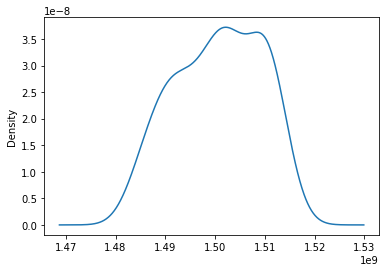

In [15]:
_ = df_pilots["created"].plot(kind="density")

In [16]:
df_pilots.head(3)

,rating,banned,created
0,4.907038,0,1502025346
1,4.089292,0,1503467860
2,4.870246,0,1497169652


Nice!

## Passengers

We're going to do the same for our 1,000 passengers, but relax the skew in the distribution of their ratings:

In [17]:
passenger_ratings = np.concatenate((
    stats.norm.rvs(loc=4.5, scale=0.3, size=500),
    stats.skewnorm.rvs(a=-1, loc=4, scale=1, size=500)
)).clip(0.01, 4.99)

df_passengers = pd.DataFrame({"rating" : passenger_ratings}, index=[range(len(passenger_ratings))])

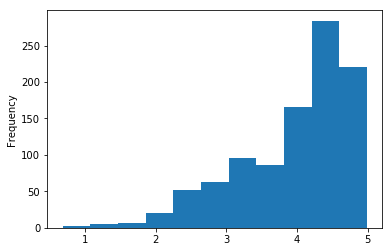

In [18]:
_ = df_passengers["rating"].plot(kind="hist", bins=11)

We'll also slightly reduce the probability of a passenger having been banned from the service:

In [19]:
df_passengers["banned"] = 0

pct_75 = df_passengers["rating"].quantile(0.75)
pct_50 = df_passengers["rating"].quantile(0.50)

passengers_abv_75th_pct = (df_passengers["rating"] >= pct_75)
passengers_abv_50th_pct = ((df_passengers["rating"] >= pct_50) & (df_passengers["rating"] < pct_75))
passengers_blw_50th_pct = (df_passengers["rating"] < pct_50)

df_passengers.loc[passengers_abv_75th_pct, "banned"] = np.random.choice([1, 0], size=250, p=[0.03, 0.97])
df_passengers.loc[passengers_abv_50th_pct, "banned"] = np.random.choice([1, 0], size=250, p=[0.07, 0.93]) 
df_passengers.loc[passengers_blw_50th_pct, "banned"] = np.random.choice([1, 0], size=500, p=[0.13, 0.87]) 

In [20]:
# stacked histogram!

In [21]:
passenger_timestamps = timestamps_between(str_2017, end_2017, 1000)
df_passengers["created"] = passenger_timestamps

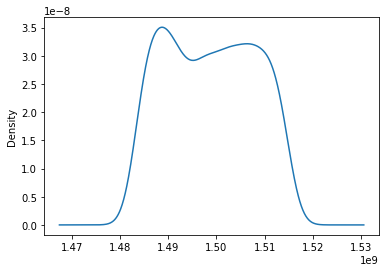

In [22]:
_ = df_passengers["created"].plot(kind="density")

In [23]:
df_passengers.head(3)

,rating,banned,created
0,4.672831,0,1507195888
1,4.513382,0,1489547541
2,4.088261,0,1490255231


## Trips

This is the big one. Let's break it down into its component parts:

* id - integer
* pilot - integer
* passenger - integer
* planet - id

Let's start by assigning pilots and passengers to planets. For sanity's sake, we'll make the assumption that neither pilots nor passengers ever participate in trips outside their home planets.

In [24]:
probs_planets = [0.05, 0.03, 0.18, 0.34, 0.10, 0.16, 0.14]

In [25]:
pilot_planets = pd.DataFrame({
    "planet": np.random.choice(df_planets.index, size=len(df_pilots), p=probs_planets)
}, index=[range(len(df_pilots))])

passenger_planets = pd.DataFrame({
    "planet": np.random.choice(df_planets.index, size=len(df_passengers), p=probs_planets)
}, index=[range(len(df_passengers))])

We'll suppose that 40% of our pilots are providing roughly 50% of the 10,000 trips.

In [26]:
def split_indexes(df, split_size):
    a = np.random.choice(df.index, size=split_size, replace=False)
    b = np.array(df.copy().drop(a).index)
    return a, b

In [27]:
pilots_40_idx, pilots_60_idx = split_indexes(df_pilots, 40)

trip_pilots = np.concatenate((
    np.random.choice(pilots_40_idx, size=5000, replace=True),
    np.random.choice(pilots_60_idx, size=5000, replace=True)
))

df_trips = pd.DataFrame({"pilot": trip_pilots}, index=[range(len(trip_pilots))])

Which gives us a wonky-looking bimodal distribution for trips per pilot:

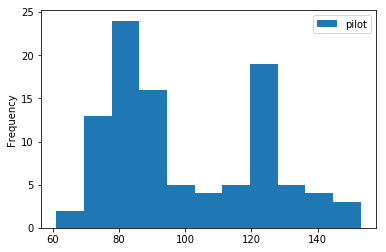

In [28]:
_ = pd.DataFrame(df_trips["pilot"].value_counts()).plot(kind="hist", bins=11)

Now let's assign a planet to each trip depending on the pilot's planet:

In [29]:
df_trips = pd.merge(df_trips, pilot_planets, how="left", left_on="pilot", right_index=True)

Now we can assign passengers to trips that took place on their planet.

In [31]:
df_trips["passenger"] = None
for idx, row in df_trips.iterrows():
    passengers_from_planet = passenger_planets[passenger_planets["planet"] == row["planet"]]
    df_trips.loc[idx, "passenger"] = row["passenger"] = np.random.choice(passengers_from_planet.index)

And the way we do this results in a more normal-looking distribution:

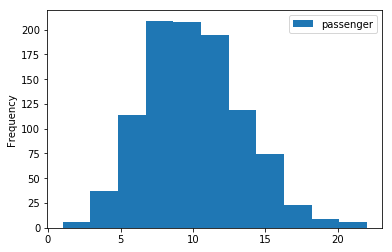

In [44]:
_ = pd.DataFrame(df_trips["passenger"].value_counts()).plot(kind="hist", bins=11)

In [30]:
df_trips.head(3)

,pilot,planet
0,4,5
1,23,2
2,55,6


* trip_completed - boolean
* trip_requested - timestamp
* trip_started - timestamp
* trip_ended - timestamp

Let's say the likelihood of a trip being completed is uniform across the population of trips.

In [33]:
trips_completed = stats.binom.rvs(n=1, p=0.95, size=len(df_trips))
df_trips["trip_completed"] = trips_completed

A trip can only be requested after both the pilot and passenger's accounts have been created.

In [50]:
max_trip = int((end_2017 - datetime.datetime(1970, 1, 1)).total_seconds())

In [81]:
for idx, row in df_trips.iterrows():
    
    pilot_created = df_pilots.loc[row["pilot"], "created"]
    passenger_created = df_passengers.loc[row["passenger"], "created"]
    min_trip = max(pilot_created, passenger_created)
    
    df_trips.loc[idx, "trip_requested"] = np.random.randint(min_trip, max_trip) + min_trip

Remember that pilot and passenger account creation is distributed uniformly throughout the year. This means that trips become more likely to take place as the year goes on:

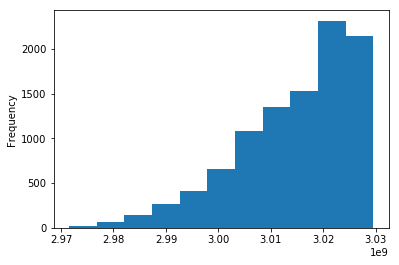

In [87]:
_ = df_trips.trip_requested.plot(kind="hist", bins=11)

Trips start between 1-15 minutes after they are requested.

In [94]:
for idx, row in df_trips.iterrows():
    df_trips.loc[idx, "trip_started"] = row["trip_requested"] + np.random.randint(60, 60 * 15)

And end between 5-60 minutes after they start.

In [95]:
for idx, row in df_trips.iterrows():
    df_trips.loc[idx, "trip_ended"] = row["trip_started"] + np.random.randint(60 * 5, 60 * 60)

Trips can have a start and end time without having been completed. What we don't want is for any pilot or passenger to start a trip while they have a trip ongoing.

In [96]:
df_trips.head(3)

,pilot,planet,passenger,trip_completed,trip_requested,trip_started,trip_ended
0,4,5,141,1,2.991225e+09,2.991226e+09,2.991227e+09
1,23,2,455,1,3.025888e+09,3.025889e+09,3.025891e+09
2,55,6,13,1,3.002399e+09,3.002399e+09,3.002401e+09


* price - integer
* pilot_rating - integer
* passenger_rating - integer

Price is determined from the duration of the trip, and is slightly higher if the trip takes place during daylight hours.

We can use the same quantile groups to randomly assign a trip rating to pilots:

As well as passengers:

We have our datasets! SUCH BEAUTIES.

What kinds of questions can we try to answer with them?